# ABInBev Case - Interactive Queries

Use this notebook to query the data processed by the pipeline. Tables are loaded as temporary views.

In [1]:
import os
from pyspark.sql import SparkSession

# Configurar JAVA_HOME para Java 17 (necessário para compatibilidade com Spark/Hadoop)
os.environ["JAVA_HOME"] = "/opt/homebrew/opt/openjdk@17/libexec/openjdk.jdk/Contents/Home"

# Configurar SparkSession com Delta Lake
spark = (SparkSession.builder
    .appName("ABInBev_Interactive_Query")
    .config("spark.jars.packages", "io.delta:delta-spark_2.12:3.2.0")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
    .getOrCreate())

# Caminho base dos dados (assumindo execucao na raiz do projeto ou ajustando path)
DATA_DIR = "../data" if os.path.exists("../data") else "data"

print(f"Spark Version: {spark.version}")
print(f"Data Directory: {DATA_DIR}")
print(f"JAVA_HOME: {os.environ.get('JAVA_HOME')}")

25/12/19 16:24:02 WARN Utils: Your hostname, Michaels-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.5 instead (on interface en0)
25/12/19 16:24:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/michaelsantos/.ivy2/cache
The jars for the packages stored in: /Users/michaelsantos/.ivy2/jars
io.delta#delta-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-a1a6fd28-1d5a-41c3-8049-16f1ab7ffe32;1.0
	confs: [default]
	found io.delta#delta-spark_2.12;3.2.0 in central
	found io.delta#delta-storage;3.2.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 69ms :: artifacts dl 3ms
	:: modules in use:
	io.delta#delta-spark_2.12;3.2.0 from central in [default]
	io.delta#delta-storage;3.2.0 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	------------------------------------------------------

:: loading settings :: url = jar:file:/Users/michaelsantos/Library/Caches/pypoetry/virtualenvs/abinbev-case-h6w4gakr-py3.12/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


25/12/19 16:24:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Spark Version: 3.5.7
Data Directory: ../data
JAVA_HOME: /opt/homebrew/opt/openjdk@17/libexec/openjdk.jdk/Contents/Home


## 1. Load Tables
Loading tables from Silver, Gold, and Consumption layers.

In [2]:
# Silver
spark.read.format("delta").load(f"{DATA_DIR}/silver/silver_sales_enriched").createOrReplaceTempView("silver_sales")
spark.read.format("delta").load(f"{DATA_DIR}/silver/silver_channel_features").createOrReplaceTempView("silver_channels")

# Gold
spark.read.format("delta").load(f"{DATA_DIR}/gold/gold_sales_enriched").createOrReplaceTempView("gold_sales")

# Consumption (Dimensions & Facts)
spark.read.format("delta").load(f"{DATA_DIR}/consumption/dim_date").createOrReplaceTempView("dim_date")
spark.read.format("delta").load(f"{DATA_DIR}/consumption/dim_product").createOrReplaceTempView("dim_product")
spark.read.format("delta").load(f"{DATA_DIR}/consumption/dim_region").createOrReplaceTempView("dim_region")
spark.read.format("delta").load(f"{DATA_DIR}/consumption/dim_channel").createOrReplaceTempView("dim_channel")
spark.read.format("delta").load(f"{DATA_DIR}/consumption/fact_sales").createOrReplaceTempView("fact_sales")

print("Tables loaded and registered as Temp Views!")

25/12/19 16:24:13 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Tables loaded and registered as Temp Views!


## 2. Business Questions
### 2.1 Top 3 Trade Groups by Region

In [3]:
query_1 = """
SELECT 
    r.region_name,
    c.trade_group_desc,
    SUM(f.dollar_volume) as total_dollar_volume
FROM fact_sales f
JOIN dim_region r ON f.region_key = r.region_key
JOIN dim_channel c ON f.channel_key = c.channel_key
GROUP BY r.region_name, c.trade_group_desc
ORDER BY r.region_name, total_dollar_volume DESC
"""
spark.sql(query_1).show()

+-----------+----------------+-------------------+
|region_name|trade_group_desc|total_dollar_volume|
+-----------+----------------+-------------------+
|     CANADA|         GROCERY|           13111.90|
|     CANADA|        SERVICES|            8759.52|
|     CANADA|        ACADEMIC|            3931.09|
|     CANADA|   ENTERTAINMENT|            3682.47|
|     CANADA|  GOV & MILITARY|             258.80|
|     CANADA|           OTHER|              23.42|
|GREAT LAKES|         GROCERY|           31135.42|
|GREAT LAKES|        SERVICES|           16162.41|
|GREAT LAKES|        ACADEMIC|            8405.91|
|GREAT LAKES|   ENTERTAINMENT|            4956.72|
|GREAT LAKES|  GOV & MILITARY|             562.50|
|GREAT LAKES|           OTHER|             211.72|
|    MIDWEST|         GROCERY|           38038.77|
|    MIDWEST|        SERVICES|           18937.51|
|    MIDWEST|        ACADEMIC|           13694.21|
|    MIDWEST|   ENTERTAINMENT|            7604.29|
|    MIDWEST|  GOV & MILITARY| 

In [ ]:
query_teste = """
SELECT 
    r.region_name,
    c.trade_group_desc,
    SUM(f.dollar_volume) as total_dollar_volume
FROM fact_sales f

"""
spark.sql(query_1).show()

### 2.2 Sales by Brand per Month

In [4]:
query_2 = """
SELECT 
    p.brand_nm,
    d.year,
    d.month,
    SUM(f.dollar_volume) as total_volume
FROM fact_sales f
JOIN dim_product p ON f.product_key = p.product_key
JOIN dim_date d ON f.date_key = d.date_key
GROUP BY p.brand_nm, d.year, d.month
ORDER BY p.brand_nm, d.year, d.month
"""
spark.sql(query_2).show()

+----------+----+-----+------------+
|  brand_nm|year|month|total_volume|
+----------+----+-----+------------+
|     GRAPE|2006|    3|        7.50|
|     LEMON|2006|    1|    52688.62|
|     LEMON|2006|    2|    61392.38|
|     LEMON|2006|    3|    49964.63|
| RASPBERRY|2006|    1|    41556.05|
| RASPBERRY|2006|    2|    52058.17|
| RASPBERRY|2006|    3|    47978.19|
|STRAWBERRY|2006|    1|    38849.29|
|STRAWBERRY|2006|    2|    34511.56|
|STRAWBERRY|2006|    3|    34544.60|
+----------+----+-----+------------+



## 3. Observability & Control
Analysis of pipeline execution metadata and data quality issues.

In [5]:
# Load Process Control
spark.read.format("delta").load(f"{DATA_DIR}/control/process_control").createOrReplaceTempView("process_control")

# Load Quarantine (Handle if empty/missing)
try:
    spark.read.format("delta").load(f"{DATA_DIR}/control/quarantine").createOrReplaceTempView("quarantine")
    print("Control & Quarantine tables loaded.")
except Exception as e:
    print(f"Quarantine table empty (Clean Run). Creating empty view for demo compatibility.")
    # Create empty DataFrame with correct schema
    schema_ddl = "quarantine_id STRING, batch_id STRING, source_table STRING, target_table STRING, record_data STRING, error_type STRING, error_code STRING, error_description STRING, dq_rule_name STRING, is_known_rule BOOLEAN, reprocessed BOOLEAN, reprocess_batch_id STRING, created_at TIMESTAMP, updated_at TIMESTAMP"
    spark.createDataFrame([], schema=schema_ddl).createOrReplaceTempView("quarantine")

Quarantine table empty (Clean Run). Creating empty view for demo compatibility.


### 3.1 Recent Pipeline Executions

In [6]:
query_control = """
SELECT 
    batch_id,
    layer,
    table_name,
    status,
    duration_seconds,
    records_read,
    records_written,
    records_quarantined
FROM process_control
ORDER BY start_timestamp DESC
LIMIT 20
"""
spark.sql(query_control).show(truncate=False)

+---------------+-----------+---------------------------+-------+----------------+------------+---------------+-------------------+
|batch_id       |layer      |table_name                 |status |duration_seconds|records_read|records_written|records_quarantined|
+---------------+-----------+---------------------------+-------+----------------+------------+---------------+-------------------+
|20251219_161840|consumption|agg_sales_brand_region     |SUCCESS|0.00            |22          |22             |0                  |
|20251219_161840|consumption|agg_sales_brand_month      |SUCCESS|0.00            |10          |10             |0                  |
|20251219_161840|consumption|agg_sales_region_tradegroup|SUCCESS|0.00            |42          |42             |0                  |
|20251219_161840|consumption|fact_sales                 |SUCCESS|0.00            |1894        |1894           |0                  |
|20251219_161840|consumption|dim_channel                |SUCCESS|0.00       

### 3.2 Quarantine Analysis (if any)

In [7]:
spark.sql("SELECT * FROM quarantine LIMIT 10").show()

+-------------+--------+------------+------------+-----------+----------+----------+-----------------+------------+-------------+-----------+------------------+----------+----------+
|quarantine_id|batch_id|source_table|target_table|record_data|error_type|error_code|error_description|dq_rule_name|is_known_rule|reprocessed|reprocess_batch_id|created_at|updated_at|
+-------------+--------+------------+------------+-----------+----------+----------+-----------------+------------+-------------+-----------+------------------+----------+----------+
+-------------+--------+------------+------------+-----------+----------+----------+-----------------+------------+-------------+-----------+------------------+----------+----------+



### 3.3 Visual Observability
Graphical representation of execution metadata.

<Figure size 1400x700 with 0 Axes>

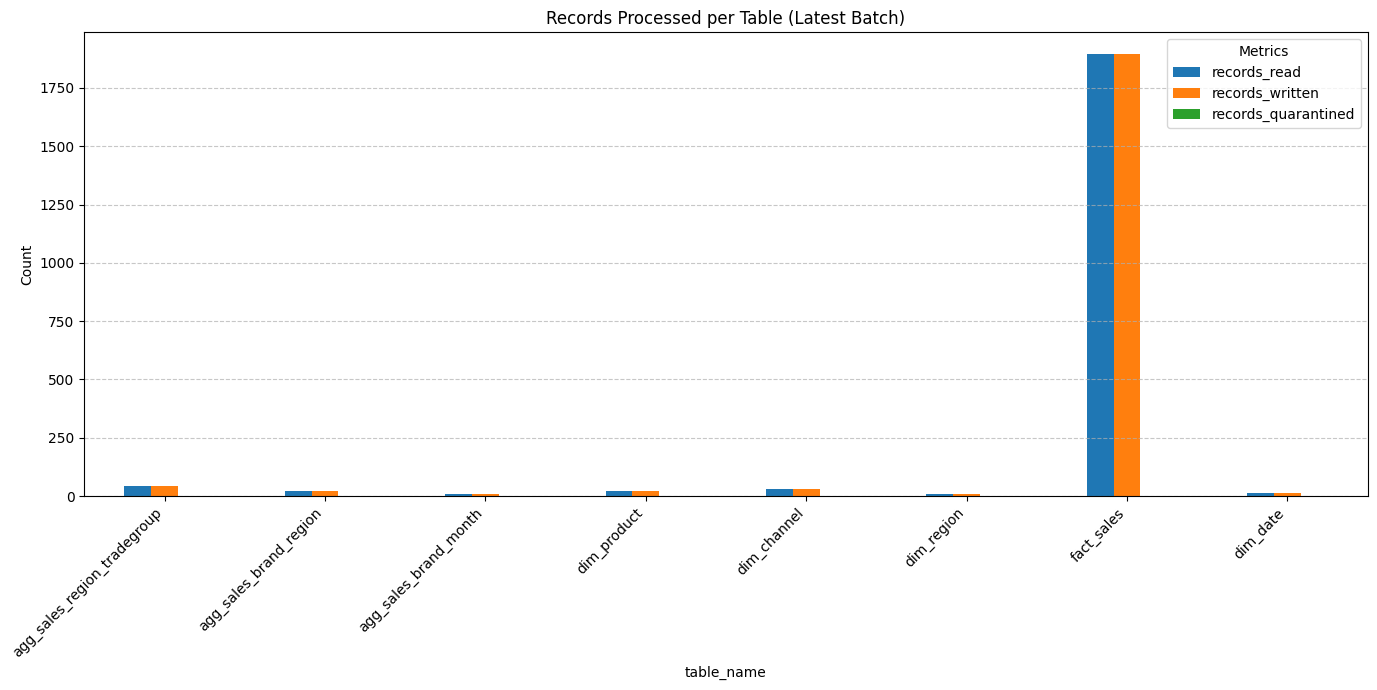

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Fetch Process Control Data for Charts
pdf_control = spark.sql("""
    SELECT table_name, records_read, records_written, records_quarantined 
    FROM process_control 
    WHERE batch_id = (SELECT MAX(batch_id) FROM process_control)
""").toPandas()

# Create Bar Chart
if not pdf_control.empty:
    plt.figure(figsize=(14, 7))
    ax = pdf_control.set_index('table_name')[['records_read', 'records_written', 'records_quarantined']].plot(kind='bar', figsize=(14, 7))
    plt.title('Records Processed per Table (Latest Batch)')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Metrics')
    plt.tight_layout()
    plt.show()
else:
    print("No process data found to plot.")

## 4. Governance & Architecture
Evidence of the underlying engineering architecture for Data Governance and Observability.
Although running locally, these configurations define the behavior in a production cloud environment.

### 4.1 Access Policies & Governance
Configuration defining access control and data sensitivity levels (e.g. PII handling).

In [9]:
import os

# Determine project root to find config files
# Assuming notebook is in 'notebooks/' directory
PROJECT_ROOT = ".." if os.path.exists("../config") else "."

policy_path = f"{PROJECT_ROOT}/config/governance_policies.yaml"

if os.path.exists(policy_path):
    print(f"--- Loading Policy Configuration: {policy_path} ---\n")
    print(open(policy_path).read())
else:
    print(f"Config file not found at {policy_path}. Checked at: {os.path.abspath(policy_path)}")

--- Loading Policy Configuration: ../config/governance_policies.yaml ---

# ==============================================================================
# ABInBev Case - Governance Policies
# ==============================================================================
#
# Este arquivo define as politicas de governanca de dados.
#
# ==============================================================================

# ------------------------------------------------------------------------------
# Politicas de Acesso por Camada
# ------------------------------------------------------------------------------

access_policies:
  landing:
    description: "Arquivos brutos - Acesso restrito a engenharia de dados"
    read:
      - role: data_engineer
      - role: admin
    write:
      - role: data_engineer
      - role: admin
    
  bronze:
    description: "Dados brutos em Delta - Acesso restrito a engenharia"
    read:
      - role: data_engineer
      - role: data_scientist
      - role

### 4.2 Observability & Alerting Rules
Prometheus alert definitions for pipeline health monitoring.

In [10]:
alert_path = f"{PROJECT_ROOT}/config/alert_rules.yml"

if os.path.exists(alert_path):
    print(f"--- Loading Alert Rules: {alert_path} ---\n")
    print(open(alert_path).read())
else:
    print(f"Config file not found at {alert_path}")

--- Loading Alert Rules: ../config/alert_rules.yml ---

# Prometheus Alert Rules for ABInBev Case
# =========================================

groups:
  - name: spark_alerts
    interval: 30s
    rules:
      - alert: SparkJobFailed
        expr: spark_job_status == 0
        for: 1m
        labels:
          severity: critical
        annotations:
          summary: "Spark job failed"
          description: "Spark job {{ $labels.job_name }} has failed."

      - alert: SparkExecutorDown
        expr: up{job="spark-executors"} == 0
        for: 2m
        labels:
          severity: warning
        annotations:
          summary: "Spark executor is down"
          description: "Spark executor {{ $labels.instance }} has been down for more than 2 minutes."

      - alert: HighMemoryUsage
        expr: (spark_executor_memory_used / spark_executor_memory_total) * 100 > 90
        for: 5m
        labels:
          severity: warning
        annotations:
          summary: "High memory usage 

### 4.3 Data Catalog Integration (OpenMetadata)
Source code responsible for registering table metadata and lineage.

In [11]:
ingest_path = f"{PROJECT_ROOT}/src/governance/ingest_metadata.py"

if os.path.exists(ingest_path):
    print(f"--- Source: {ingest_path} ---\n")
    # Print first 50 lines to show import structure and class definition
    with open(ingest_path) as f:
        print("".join(f.readlines()[:50]))
        print("... (truncated)")
else:
    print(f"Source file not found at {ingest_path}")

--- Source: ../src/governance/ingest_metadata.py ---

"""
OpenMetadata Ingestion Script

Script para ingerir metadados das tabelas Delta Lake no OpenMetadata.
Deve ser executado apos cada pipeline run para manter o catalogo atualizado.
"""

import logging
import os
from typing import Any, Dict, Optional

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


def get_openmetadata_config() -> Dict[str, Any]:
    """
    Retorna a configuracao de conexao com o OpenMetadata.

    Environment Variables:
        OPENMETADATA_HOST: URL do servidor OpenMetadata
        OPENMETADATA_TOKEN: Token de autenticacao (opcional)
    """
    host = os.getenv("OPENMETADATA_HOST", "http://localhost:8585/api")
    token = os.getenv("OPENMETADATA_TOKEN", "")

    config = {
        "source": {
            "type": "deltalake",
            "serviceName": "abinbev_datalake",
            "serviceConnection": {
                "config": {
                    "type": "DeltaLake",
        